# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Wednesday, March 15, 2023 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [1]:
import os

%matplotlib inline
import sys

import eli5
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
    roc_auc_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier

sys.path.append("../../lectures/code")
from utils import mean_std_cross_val_scores

import warnings
warnings.filterwarnings('ignore')

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a customer will cancel the reservation they have made at a hotel. 
For this problem, you will use [Reservation Cancellation Prediction Dataset](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). In this data set, there are about 18.000 examples and 18 features (including the target), and the goal is to estimate whether a person will cancel their booking; this column is labeled "booking_status" in the data (1 = canceled). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/datasets/gauravduttakiit/reservation-cancellation-prediction?select=train__dataset.csv). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

1. Our goal is to facilitate hotels to identify potential cancellation bookings which helps them control their costs and expenses. This is a classification problem as we are using several numerical/binary features to predict whether customers will cancel their booking. At first glance, the features all represent important attributes of a hotel room booking and it is not necessary to drop any of those. 
2. The dataset is downloaded and is stored as a pandas dataframe: 

In [2]:
reservation_df = pd.read_csv("train__dataset.csv")

<br><br>

## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [3]:
train_df, test_df = train_test_split(reservation_df, test_size=0.2, random_state=49)

<br><br>

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

1. We are performing preliminary exploratory data analysis (EDA) on the train set. By using the methods `.info()`, `.describe()` and `.shape`, we get the following information and summary statistics: 

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14509 entries, 9829 to 426
Data columns (total 18 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   no_of_adults                          14509 non-null  int64  
 1   no_of_children                        14509 non-null  int64  
 2   no_of_weekend_nights                  14509 non-null  int64  
 3   no_of_week_nights                     14509 non-null  int64  
 4   type_of_meal_plan                     14509 non-null  int64  
 5   required_car_parking_space            14509 non-null  int64  
 6   room_type_reserved                    14509 non-null  int64  
 7   lead_time                             14509 non-null  int64  
 8   arrival_year                          14509 non-null  int64  
 9   arrival_month                         14509 non-null  int64  
 10  arrival_date                          14509 non-null  int64  
 11  market_segment

In [5]:
train_df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
count,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000,14509.000000
mean,1.847474,0.109932,0.811358,2.206906,0.317803,0.032532,0.340478,85.869254,2017.819767,7.452271,15.656972,0.804604,0.025088,0.021780,0.144669,103.825130,0.622303,0.328899
std,0.516975,0.415582,0.875512,1.425207,0.630732,0.177413,0.772602,87.089570,0.384395,3.062174,8.760640,0.645607,0.156397,0.366723,1.626763,35.826965,0.793646,0.469830
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000,80.750000,0.000000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,1.000000,0.000000,0.000000,0.000000,99.900000,0.000000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,0.000000,0.000000,128.000000,2018.000000,10.000000,23.000000,1.000000,0.000000,0.000000,0.000000,121.500000,1.000000,1.000000
max,4.000000,9.000000,7.000000,17.000000,3.000000,1.000000,6.000000,443.000000,2018.000000,12.000000,31.000000,4.000000,1.000000,13.000000,58.000000,540.000000,5.000000,1.000000


In [6]:
train_df.shape

(14509, 18)

2.  Summary statistic 1: Mean of `booking_status` = `0.328899`. Around 32.9% of the customers cancelled their booking and 67.1% of them did not. \
    Summary statistic 2: Mean of `lead_time` = `85.869254`. People book their rooms on average (around) `86` days in advance before the arrival date. \
    Visualization 1: Pairwise correlation heatmap plot between all features of the training dataset

<AxesSubplot: >

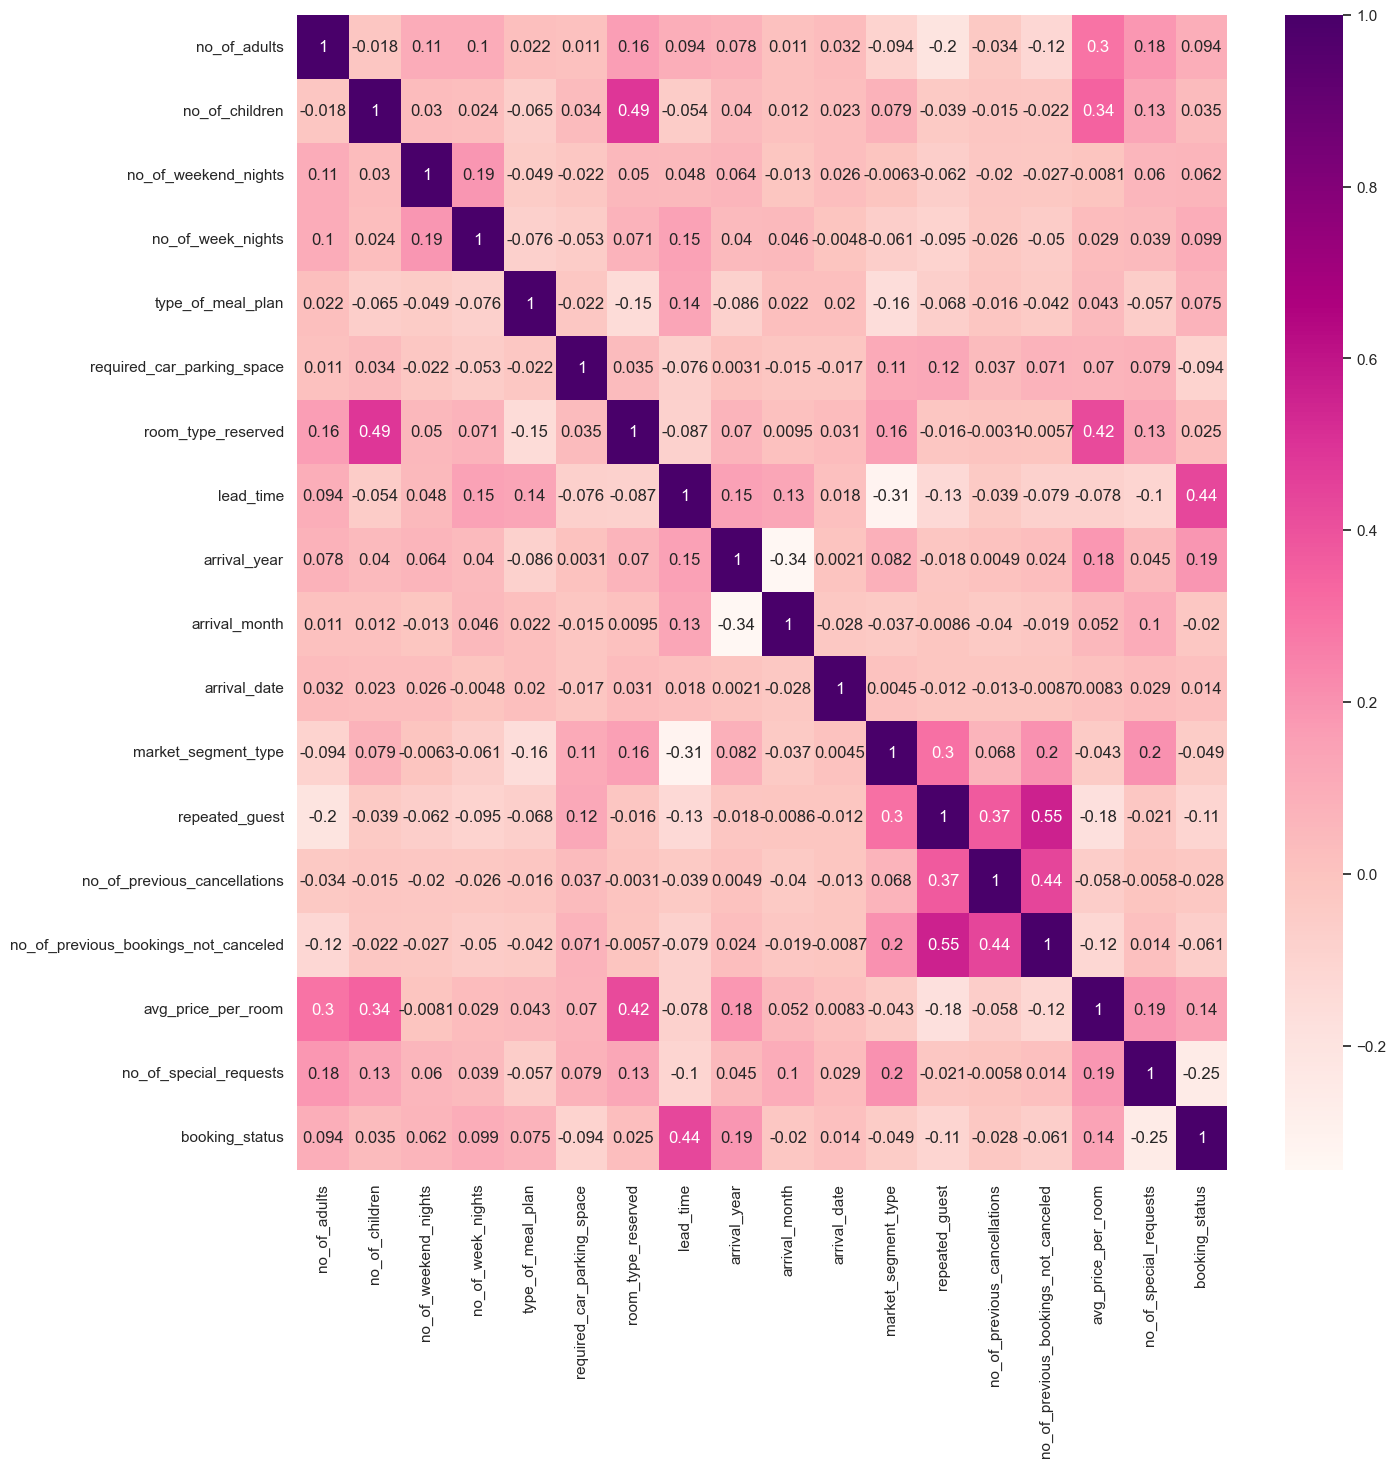

In [7]:
corr_matrix = train_df.corr()
plt.figure(figsize=(15, 15))
sns.set(font_scale=1)
sns.heatmap(corr_matrix, annot=True, cmap=plt.cm.RdPu)

2.  Visualization 1 description: Our target variable `booking_status` is moderately correlated with `lead_time`, with a correlation coefficient of `0.44`. \
    Visualization 2: Relationship between `arrival_date` and `booking_status`

In [8]:
dates = sorted(train_df["arrival_date"].unique().tolist())
date_cancelled_proportion = list()
for date in dates:
    booking_status_df = train_df[train_df["arrival_date"] == date]
    cancelled_proportion = booking_status_df["booking_status"].mean()
    date_cancelled_proportion.append(cancelled_proportion)

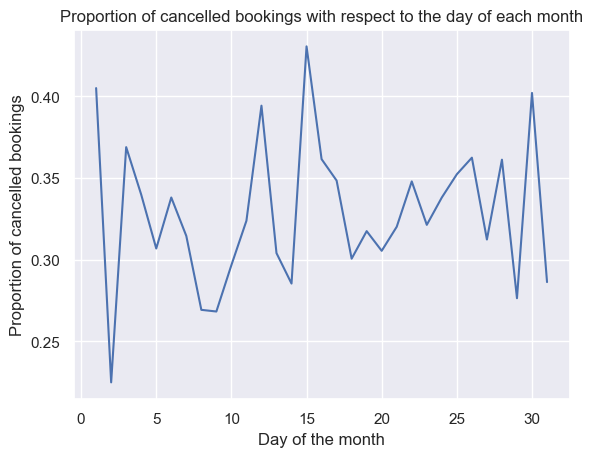

In [9]:
plt.plot(dates, date_cancelled_proportion)
plt.title("Proportion of cancelled bookings with respect to the day of each month")
plt.xlabel("Day of the month")
plt.ylabel("Proportion of cancelled bookings")
plt.show()

2.  Visualization 2 description: From the line plot above, we see that there is no apparent trend between the proportion of cancelled bookings and the day of each month, which is consistent with the correlation heatmap above (a correlation of roughly `0`). 

3.  By viewing the summary table of the `train_df`, we can see that the datatypes of the features are either of class `int` or class `float`. There are no missing values in the training dataset. \
    Our prediction task is to predict whether a booking of a hotel will be cancelled or not. Our outcome variable `booking_status` is a binary variable, taking values of either `0` and `1`. 

4.  Since this is a classification task and there is a slight class imbalance in the dataset, the following scores and/metrics will be used for evaluated the model: 
    * Accuracy (act as a baseline score)
    * Precision
    * Recall
    * f1-score
    * ROC/AUC

In [10]:
scoring = {
    "accuracy": "accuracy", 
    "precision": "precision", 
    "recall": "recall", 
    "f1": "f1", 
    "roc_auc": "roc_auc"
}

<br><br>

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

Feature engineering is carried out and there are two newly defined features: 

1. `is_public_holiday`: 
    Making reference to the official public holidays for [2017](https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=CELEX%3A32015D1202%2801%29) and [2018](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A32017D0217%2801%29), we define `is_public_holiday` according to the dates listed in the European Law. Moreover, if a weekend directly precedes or follows a public holiday, the corresponding dates will also be marked as `is_public_holiday = 1`. Otherwise, `is_public_holiday = 0`. 

In [11]:
from datetime import datetime
list_of_holidays = [
    datetime(2017, 1, 1), datetime(2017, 1, 2), datetime(2017, 4, 13), datetime(2017, 4, 14), datetime(2017, 4, 15), datetime(2017, 4, 16), 
    datetime(2017, 4, 29), datetime(2017, 4, 30), datetime(2017, 5, 1), datetime(2017, 5, 9), datetime(2017, 5, 25), datetime(2017, 5, 26), 
    datetime(2017, 5, 27), datetime(2017, 5, 28), datetime(2017, 6, 3), datetime(2017, 6, 4), datetime(2017, 6, 5), datetime(2017, 7, 21), 
    datetime(2017, 7, 22), datetime(2017, 7, 23), datetime(2017, 8, 15), datetime(2017, 11, 1), datetime(2017, 11, 2), datetime(2017, 12, 23), 
    datetime(2017, 12, 24), datetime(2017, 12, 25), datetime(2017, 12, 26), datetime(2017, 12, 27), datetime(2017, 12, 28), datetime(2017, 12, 29), 
    datetime(2017, 12, 30), datetime(2017, 12, 31), datetime(2018, 1, 1), datetime(2018, 1, 2), datetime(2018, 3, 29), datetime(2018, 3, 30), 
    datetime(2018, 3, 31), datetime(2018, 4, 1), datetime(2018, 4, 2), datetime(2018, 5, 1), datetime(2018, 5, 9), datetime(2018, 5, 10), 
    datetime(2018, 5, 11), datetime(2018, 5, 12), datetime(2018, 5, 13), datetime(2018, 5, 19), datetime(2018, 5, 20), datetime(2018, 5, 12), 
    datetime(2018, 8, 15), datetime(2018, 11, 1), datetime(2018, 11, 2), datetime(2018, 11, 3), datetime(2018, 11, 4), datetime(2018, 12, 22), 
    datetime(2018, 12, 23), datetime(2018, 12, 24), datetime(2018, 12, 25), datetime(2018, 12, 26), datetime(2018, 12, 27), datetime(2018, 12, 28), 
    datetime(2018, 12, 29), datetime(2018, 12, 30), datetime(2018, 12, 31)
]

In [12]:
def is_public_holiday(date):
    year = date["arrival_year"]
    month = date["arrival_month"]
    day = date["arrival_date"]
    try:
        dt = datetime(year, month, day)
    except ValueError: # Feb 29 exists in a non-leap year in the training data
        dt = datetime(year, month, day-1)
    return 1 if dt in list_of_holidays else 0

In [13]:
train_df = train_df.assign(
    is_public_holiday=train_df[["arrival_year", "arrival_month", "arrival_date"]].apply(is_public_holiday, axis=1)
)

test_df = test_df.assign(
    is_public_holiday=test_df[["arrival_year", "arrival_month", "arrival_date"]].apply(is_public_holiday, axis=1)
)

2.  `avg_price_per_person`: 
    The average price of the room per person. It is calculated by `avg_price_per_room` divided by the sum of `no_of_adults` and `no_of_children`. 

In [14]:
train_df = train_df.assign(
    avg_price_per_person=train_df["avg_price_per_room"] / (train_df["no_of_adults"] + train_df["no_of_children"])
)

test_df = test_df.assign(
    avg_price_per_person=test_df["avg_price_per_room"] / (test_df["no_of_adults"] + test_df["no_of_children"])
)

<br><br>

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

Before identifying the necessary items for preprocessing and transformation, we first separate the data into `X` and `y`. 

In [15]:
X_train = train_df.drop(columns=["booking_status"])
y_train = train_df["booking_status"]

X_test = test_df.drop(columns=["booking_status"])
y_test = test_df["booking_status"]

1. Next, we identify all the columns and determine which transformation to apply: 

In [16]:
all_features = X_train.columns.tolist()
all_features

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'is_public_holiday',
 'avg_price_per_person']

1.  The transformations to be applied are as follows: 
    * One-hot encoding using `OneHotEncoder`, for columns `type_of_meal_plan`, `room_type_reserved`, `arrival_year`, `arrival_month`, `arrival_date`, `market_segment_type`;
    * Scaling using `StandardScaler`, for columns `lead_time`, `avg_price_per_room`, `avg_price_per_person`;
    * Other columns are to be passthrough. Either they are binary features, or numerical features with a small range. 

In [17]:
categorical_feats = ["type_of_meal_plan", "room_type_reserved", "arrival_year", "arrival_month", "arrival_date", "market_segment_type"]
numerical_feats = ["lead_time", "avg_price_per_room", "avg_price_per_person"]
passthrough_feats = ["no_of_adults", "no_of_children", "no_of_weekend_nights", "no_of_week_nights", "required_car_parking_space", 
                    "repeated_guest", "no_of_previous_cancellations", "no_of_previous_bookings_not_canceled", "no_of_special_requests", 
                    "is_public_holiday"]
assert set(categorical_feats + numerical_feats + passthrough_feats) == set(all_features)

2.  A column transformer is defined as follows: 

In [18]:
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown="ignore"), categorical_feats), 
    (StandardScaler(), numerical_feats), 
    ("passthrough", passthrough_feats)
)

<br><br>

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

<p style="color: red;">Remark: Part of the code (the function `mean_std_cross_val_scores`) is directly adapted from <a href="https://github.com/UBC-CS/cpsc330-2022W2/blob/main/lectures/code/utils.py#L134-L161">the code provided in the lecture</a>. </p>

1. The baseline model to be used is `DummyClassifier`. The results is as follows: 

In [19]:
pipe_baseline = make_pipeline(
    preprocessor, DummyClassifier(strategy="prior")
)
baseline_results_dict = mean_std_cross_val_scores(pipe_baseline, X_train, y_train, scoring=scoring, return_train_score=True)
baseline_results = pd.DataFrame.from_dict(baseline_results_dict).T
baseline_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)


In [20]:
model_results = pd.DataFrame(columns=baseline_results.columns)
model_results = pd.concat([model_results, baseline_results]).rename(index={0: "DummyClassifier"})
model_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DummyClassifier,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)


Both the training score and validation accuracy score is around 67%, which is approximately equal to the proportions in the majority class (class `0`). Moreover, precision, recall and f1 score are all `0` (since `DummyClassifier` does not predict any true positives) and the RUC_AUC score is `0.5`. 

<br><br>

## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

1. Using the first attempt, logistic regression has been tried as the first attempt. Results are summarized as follows: 

In [21]:
pipe_default_logit = make_pipeline(
    preprocessor, LogisticRegression(max_iter=1000, random_state=613)
)
logit_default_dict = mean_std_cross_val_scores(pipe_default_logit, X_train, y_train, scoring=scoring, return_train_score=True)
logit_default_results = pd.DataFrame.from_dict(logit_default_dict).T

In [22]:
model_results = pd.concat([model_results, logit_default_results]).rename(index={0: "LogisticRegression_C=1"})
model_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DummyClassifier,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)
LogisticRegression_C=1,0.178 (+/- 0.015),0.012 (+/- 0.001),0.807 (+/- 0.006),0.811 (+/- 0.002),0.735 (+/- 0.010),0.741 (+/- 0.004),0.649 (+/- 0.015),0.654 (+/- 0.003),0.689 (+/- 0.011),0.695 (+/- 0.003),0.875 (+/- 0.006),0.878 (+/- 0.002)


2. Hyperparameter tuning has been performed on the value of `C` in `LogisticRegression`. The tuning procedure and results are as follows: 

In [23]:
param_grid = {"logisticregression__C":  np.logspace(-3, 3, 7)}
grid_search_logit = GridSearchCV(pipe_default_logit, param_grid, cv=5, n_jobs=-1, scoring=scoring, refit=False, return_train_score=True)
grid_search_logit.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['type_of_meal_plan',
                                                                          'room_type_reserved',
                                                                          'arrival_year',
                                                                          'arrival_month',
                                                                          'arrival_date',
                                                                          'market_segment_type']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['lead_time',
                                                                          'avg_price_per_room',
                                                                          'av...
                                                                          'no_of_special_requests',
                                                                          'is_public_holiday'])])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=613))]),
             n_jobs=-1,
             param_grid={'logisticregression__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             refit=False, return_train_score=True,
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [24]:
pd.DataFrame(grid_search_logit.cv_results_)[["params", "mean_test_accuracy", "mean_test_precision", "mean_test_recall", "mean_test_f1", "mean_test_roc_auc", 
                                            "rank_test_accuracy", "rank_test_precision", "rank_test_recall", "rank_test_f1", "rank_test_roc_auc"]]

,params,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_precision,rank_test_recall,rank_test_f1,rank_test_roc_auc
0,{'logisticregression__C': 0.001},0.780895,0.806329,0.439435,0.568694,0.854817,7,1,7,7,7
1,{'logisticregression__C': 0.01},0.804191,0.751926,0.604356,0.669965,0.870862,6,2,6,6,6
2,{'logisticregression__C': 0.1},0.808946,0.742558,0.641657,0.688364,0.874801,1,3,5,5,5
3,{'logisticregression__C': 1.0},0.807361,0.734581,0.648783,0.688940,0.874828,5,7,4,4,3
4,{'logisticregression__C': 10.0},0.807706,0.734898,0.649831,0.689664,0.874810,3,6,1,2,4
5,{'logisticregression__C': 100.0},0.807706,0.734999,0.649621,0.689590,0.874829,3,5,3,3,2
6,{'logisticregression__C': 1000.0},0.807775,0.735062,0.649831,0.689735,0.874838,2,4,2,1,1


2. Recalling the business context that we are trying to help hotels predicting whether a booking will be cancelled or not, it is better to have less false positives (predicted as cancelled booking but the customer showed up) because this can seriously damage the reputation of the hotel. At the same time, fewer false negatives (predicted as not cancelled booking but the customer did not show up) is also preferred because the hotel needs to prepare for the arrival of the customer a few days in advanced. Therefore, we should select our model based on the highest f1-score. 
    Based on the discussion above, the `LogisticRegression` model with `C=1` is to be selected. 

3.  The validation scores and the corresponding standard deviations are reported as below: 

In [25]:
model_results.loc[["LogisticRegression_C=1"]][["test_accuracy", "test_precision", "test_recall", "test_f1", "test_roc_auc"]]

,test_accuracy,test_precision,test_recall,test_f1,test_roc_auc
LogisticRegression_C=1,0.807 (+/- 0.006),0.735 (+/- 0.010),0.649 (+/- 0.015),0.689 (+/- 0.011),0.875 (+/- 0.006)


4.  The full table of the results, together with the baseline model, is summarized as below: 

In [26]:
model_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DummyClassifier,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)
LogisticRegression_C=1,0.178 (+/- 0.015),0.012 (+/- 0.001),0.807 (+/- 0.006),0.811 (+/- 0.002),0.735 (+/- 0.010),0.741 (+/- 0.004),0.649 (+/- 0.015),0.654 (+/- 0.003),0.689 (+/- 0.011),0.695 (+/- 0.003),0.875 (+/- 0.006),0.878 (+/- 0.002)


<br><br>

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

1.  We are trying 3 other models, which are listed as follows: 
    * `RandomForestClassifier`
    * `XGBClassifier`
    * `SVC` with `kernel="rbf"`

In [27]:
pipe_rf = make_pipeline(
    preprocessor, RandomForestClassifier(random_state=403)
)
rf_results_dict = mean_std_cross_val_scores(pipe_rf, X_train, y_train, scoring=scoring, return_train_score=True)
rf_results = pd.DataFrame.from_dict(rf_results_dict).T
model_results = pd.concat([model_results, rf_results]).rename(index={0: "RandomForestClassifier"})

In [28]:
pipe_xgb = make_pipeline(
    preprocessor, XGBClassifier(random_state=430)
)
xgb_results_dict = mean_std_cross_val_scores(pipe_xgb, X_train, y_train, scoring=scoring, return_train_score=True)
xgb_results = pd.DataFrame.from_dict(xgb_results_dict).T
model_results = pd.concat([model_results, xgb_results]).rename(index={0: "XGBClassifier"})

In [29]:
pipe_svm = make_pipeline(
    preprocessor, SVC(random_state=407)
)
svm_results_dict = mean_std_cross_val_scores(pipe_svm, X_train, y_train, scoring=scoring, return_train_score=True)
svm_results = pd.DataFrame.from_dict(svm_results_dict).T
model_results = pd.concat([model_results, svm_results]).rename(index={0: "SVC"})

2. The results are summarized as below: 

In [30]:
model_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DummyClassifier,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)
LogisticRegression_C=1,0.178 (+/- 0.015),0.012 (+/- 0.001),0.807 (+/- 0.006),0.811 (+/- 0.002),0.735 (+/- 0.010),0.741 (+/- 0.004),0.649 (+/- 0.015),0.654 (+/- 0.003),0.689 (+/- 0.011),0.695 (+/- 0.003),0.875 (+/- 0.006),0.878 (+/- 0.002)
RandomForestClassifier,0.838 (+/- 0.017),0.095 (+/- 0.005),0.890 (+/- 0.007),0.996 (+/- 0.000),0.868 (+/- 0.004),0.996 (+/- 0.001),0.787 (+/- 0.023),0.992 (+/- 0.001),0.825 (+/- 0.014),0.994 (+/- 0.001),0.942 (+/- 0.007),1.000 (+/- 0.000)
XGBClassifier,0.318 (+/- 0.028),0.022 (+/- 0.001),0.887 (+/- 0.008),0.940 (+/- 0.002),0.855 (+/- 0.017),0.931 (+/- 0.004),0.789 (+/- 0.021),0.882 (+/- 0.003),0.821 (+/- 0.013),0.906 (+/- 0.003),0.946 (+/- 0.006),0.987 (+/- 0.001)
SVC,2.625 (+/- 0.052),2.023 (+/- 0.017),0.843 (+/- 0.004),0.859 (+/- 0.003),0.799 (+/- 0.017),0.824 (+/- 0.003),0.702 (+/- 0.023),0.728 (+/- 0.010),0.747 (+/- 0.009),0.773 (+/- 0.006),0.904 (+/- 0.006),0.919 (+/- 0.001)


2.  From the results above, we can see that all of the three models can beat `LogisticRegression`. All of `RandomForestClassifier`, `XGBClassifier` and `SVC` outperformed `LogisticRegression` in terms of all the scoring metrics. \
    However, the `RandomForestClassifier` is clearly overfitting, as all the training scores are close to `1` and the validation scores is significantly lower than the training scores. \
    If I were to pick one model for further feature selection/hyperparameter tuning, I would pick `XGBClassifier` as it has high training and validation scores. 

<br><br>

## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

We select features for `XGBClassifier` by using `RFECV`. Within `RFECV`, we use `LogisticRegression` to select the features. 

In [31]:
pipe_xgb_rfecv = make_pipeline(
    preprocessor, 
    RFECV(LogisticRegression(max_iter=1000, random_state=1005), cv=10), 
    XGBClassifier(random_state=430)
)
pipe_xgb_rfecv.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'arrival_year',
                                                   'arrival_month',
                                                   'arrival_date',
                                                   'market_segment_type']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['lead_time',
                                                   'avg_price_per_room',
                                                   'avg_price_per_person']),
                                                 ('pass...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=430, ...))])

In [32]:
support = pipe_xgb_rfecv.named_steps["rfecv"].support_
feat_columns = np.array([
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out().tolist() + 
    numerical_feats + 
    passthrough_feats
]).flatten()
selected_feats = feat_columns[support]
print(f"No. of selected features: {len(selected_feats)} out of {len(support)}")
selected_feats

No. of selected features: 70 out of 74


array(['type_of_meal_plan_0', 'type_of_meal_plan_1',
       'type_of_meal_plan_2', 'room_type_reserved_0',
       'room_type_reserved_1', 'room_type_reserved_2',
       'room_type_reserved_3', 'room_type_reserved_4',
       'room_type_reserved_5', 'room_type_reserved_6',
       'arrival_year_2017', 'arrival_year_2018', 'arrival_month_1',
       'arrival_month_2', 'arrival_month_3', 'arrival_month_4',
       'arrival_month_5', 'arrival_month_6', 'arrival_month_7',
       'arrival_month_8', 'arrival_month_10', 'arrival_month_11',
       'arrival_month_12', 'arrival_date_1', 'arrival_date_2',
       'arrival_date_3', 'arrival_date_4', 'arrival_date_7',
       'arrival_date_8', 'arrival_date_9', 'arrival_date_10',
       'arrival_date_11', 'arrival_date_12', 'arrival_date_13',
       'arrival_date_14', 'arrival_date_15', 'arrival_date_16',
       'arrival_date_17', 'arrival_date_18', 'arrival_date_19',
       'arrival_date_20', 'arrival_date_21', 'arrival_date_22',
       'arrival_date_23'

By using `RFECV`, we see that the number of features used is similar to the number of original features used (with only `4` features fewer). 

In [33]:
xgb_rfecv_dict = mean_std_cross_val_scores(pipe_xgb_rfecv, X_train, y_train, scoring=scoring, return_train_score=True)
xgb_rfecv_results = pd.DataFrame.from_dict(xgb_rfecv_dict).T

The results are summarized as below: 

In [34]:
model_results = pd.concat([model_results, xgb_rfecv_results]).rename(index={0: "XGBClassifier with feature selection"})
model_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DummyClassifier,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)
LogisticRegression_C=1,0.178 (+/- 0.015),0.012 (+/- 0.001),0.807 (+/- 0.006),0.811 (+/- 0.002),0.735 (+/- 0.010),0.741 (+/- 0.004),0.649 (+/- 0.015),0.654 (+/- 0.003),0.689 (+/- 0.011),0.695 (+/- 0.003),0.875 (+/- 0.006),0.878 (+/- 0.002)
RandomForestClassifier,0.838 (+/- 0.017),0.095 (+/- 0.005),0.890 (+/- 0.007),0.996 (+/- 0.000),0.868 (+/- 0.004),0.996 (+/- 0.001),0.787 (+/- 0.023),0.992 (+/- 0.001),0.825 (+/- 0.014),0.994 (+/- 0.001),0.942 (+/- 0.007),1.000 (+/- 0.000)
XGBClassifier,0.318 (+/- 0.028),0.022 (+/- 0.001),0.887 (+/- 0.008),0.940 (+/- 0.002),0.855 (+/- 0.017),0.931 (+/- 0.004),0.789 (+/- 0.021),0.882 (+/- 0.003),0.821 (+/- 0.013),0.906 (+/- 0.003),0.946 (+/- 0.006),0.987 (+/- 0.001)
SVC,2.625 (+/- 0.052),2.023 (+/- 0.017),0.843 (+/- 0.004),0.859 (+/- 0.003),0.799 (+/- 0.017),0.824 (+/- 0.003),0.702 (+/- 0.023),0.728 (+/- 0.010),0.747 (+/- 0.009),0.773 (+/- 0.006),0.904 (+/- 0.006),0.919 (+/- 0.001)
XGBClassifier with feature selection,53.607 (+/- 4.053),0.022 (+/- 0.002),0.882 (+/- 0.012),0.927 (+/- 0.009),0.847 (+/- 0.019),0.912 (+/- 0.012),0.783 (+/- 0.028),0.861 (+/- 0.017),0.813 (+/- 0.020),0.886 (+/- 0.014),0.942 (+/- 0.008),0.980 (+/- 0.006)


From the summary table above, we can see that with feature selection, the `XGBClassifier` is performing worse than expected, compared to our original model without feature selection. All the scoring metrics have high variance and the fitting time of the model is extremely slow. Therefore, we will abandon the model with feature selection and choose not to use it in the remaining questions. 

<br><br>

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

We will tune the hyperparameters `learning_rate` and `n_jobs` in the `XGBClassifier` using `RandomizedSearchCV`. 

In [35]:
param_dist = {
    "xgbclassifier__learning_rate": np.logspace(-2, 2, 5), 
    "xgbclassifier__gamma": np.logspace(-2, 1, 4)
}
random_search_xgb = RandomizedSearchCV(pipe_xgb, param_dist, scoring=scoring, refit=False, random_state=25)
random_search_xgb.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('onehotencoder',
                                                                               OneHotEncoder(handle_unknown='ignore',
                                                                                             sparse=False),
                                                                               ['type_of_meal_plan',
                                                                                'room_type_reserved',
                                                                                'arrival_year',
                                                                                'arrival_month',
                                                                                'arrival_date',
                                                                                'market_segment_type']),
                                                                              ('standardscaler',
                                                                               StandardScaler(),
                                                                               ['lead_time',
                                                                                'avg_price_per_room',
                                                                                'a...
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            predictor=None,
                                                            random_state=430, ...))]),
                   param_distributions={'xgbclassifier__gamma': array([ 0.01,  0.1 ,  1.  , 10.  ]),
                                        'xgbclassifier__learning_rate': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02])},
                   random_state=25, refit=False,
                   scoring={'accuracy': 'accuracy', 'f1': 'f1',
                            'precision': 'precision', 'recall': 'recall',
                            'roc_auc': 'roc_auc'})

In [36]:
pd.DataFrame(random_search_xgb.cv_results_)[["param_xgbclassifier__learning_rate", "param_xgbclassifier__gamma", 
                                             "mean_test_accuracy", "mean_test_precision", "mean_test_recall", "mean_test_f1", "mean_test_roc_auc", 
                                            "rank_test_accuracy", "rank_test_precision", "rank_test_recall", "rank_test_f1", "rank_test_roc_auc"]]

,param_xgbclassifier__learning_rate,param_xgbclassifier__gamma,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1,mean_test_roc_auc,rank_test_accuracy,rank_test_precision,rank_test_recall,rank_test_f1,rank_test_roc_auc
0,10.0,1.0,0.740227,0.734304,0.363988,0.458211,0.645274,8,8,8,8,8
1,0.1,1.0,0.879731,0.848927,0.771794,0.808338,0.941088,2,2,4,2,2
2,1.0,0.01,0.875319,0.825360,0.787927,0.806051,0.937078,3,5,1,3,3
3,0.01,1.0,0.861604,0.820381,0.741618,0.778940,0.913977,6,6,6,6,7
4,0.1,0.1,0.880627,0.849300,0.774518,0.810055,0.941426,1,1,3,1,1
5,10.0,10.0,0.700599,0.696551,0.166205,0.258332,0.566778,10,10,10,10,10
6,0.1,10.0,0.870839,0.843607,0.745599,0.791465,0.931364,5,3,5,5,5
7,0.01,0.01,0.861259,0.820042,0.740780,0.778316,0.914065,7,7,7,7,6
8,10.0,0.01,0.727202,0.709709,0.317237,0.418400,0.622739,9,9,9,9,9
9,1.0,0.1,0.874906,0.827836,0.782903,0.804460,0.935539,4,4,2,4,4


From the results above, we can see that the `XGBClassifier` with `learning_rate=0.1` and `gamma=0.1` is the best-performing model, with the highest ranking in most of the scoring metrics (except recall). Therefore, we will select this model for testing and deployment. 

In [37]:
pipe_xgb_best = make_pipeline(
    preprocessor, XGBClassifier(learning_rate=0.1, gamma=0.1, random_state=430)
)
xgb_results_dict = mean_std_cross_val_scores(pipe_xgb, X_train, y_train, scoring=scoring, return_train_score=True)
xgb_results = pd.DataFrame.from_dict(xgb_results_dict).T
model_results = pd.concat([model_results, xgb_results]).rename(index={0: "XGBClassifier__learning_rate=0.1__gamma=0.1"})
model_results

,fit_time,score_time,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,test_roc_auc,train_roc_auc
DummyClassifier,0.011 (+/- 0.001),0.011 (+/- 0.001),0.671 (+/- 0.000),0.671 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.500 (+/- 0.000),0.500 (+/- 0.000)
LogisticRegression_C=1,0.178 (+/- 0.015),0.012 (+/- 0.001),0.807 (+/- 0.006),0.811 (+/- 0.002),0.735 (+/- 0.010),0.741 (+/- 0.004),0.649 (+/- 0.015),0.654 (+/- 0.003),0.689 (+/- 0.011),0.695 (+/- 0.003),0.875 (+/- 0.006),0.878 (+/- 0.002)
RandomForestClassifier,0.838 (+/- 0.017),0.095 (+/- 0.005),0.890 (+/- 0.007),0.996 (+/- 0.000),0.868 (+/- 0.004),0.996 (+/- 0.001),0.787 (+/- 0.023),0.992 (+/- 0.001),0.825 (+/- 0.014),0.994 (+/- 0.001),0.942 (+/- 0.007),1.000 (+/- 0.000)
XGBClassifier,0.318 (+/- 0.028),0.022 (+/- 0.001),0.887 (+/- 0.008),0.940 (+/- 0.002),0.855 (+/- 0.017),0.931 (+/- 0.004),0.789 (+/- 0.021),0.882 (+/- 0.003),0.821 (+/- 0.013),0.906 (+/- 0.003),0.946 (+/- 0.006),0.987 (+/- 0.001)
SVC,2.625 (+/- 0.052),2.023 (+/- 0.017),0.843 (+/- 0.004),0.859 (+/- 0.003),0.799 (+/- 0.017),0.824 (+/- 0.003),0.702 (+/- 0.023),0.728 (+/- 0.010),0.747 (+/- 0.009),0.773 (+/- 0.006),0.904 (+/- 0.006),0.919 (+/- 0.001)
XGBClassifier with feature selection,53.607 (+/- 4.053),0.022 (+/- 0.002),0.882 (+/- 0.012),0.927 (+/- 0.009),0.847 (+/- 0.019),0.912 (+/- 0.012),0.783 (+/- 0.028),0.861 (+/- 0.017),0.813 (+/- 0.020),0.886 (+/- 0.014),0.942 (+/- 0.008),0.980 (+/- 0.006)
XGBClassifier__learning_rate=0.1__gamma=0.1,0.336 (+/- 0.022),0.023 (+/- 0.002),0.887 (+/- 0.008),0.940 (+/- 0.002),0.855 (+/- 0.017),0.931 (+/- 0.004),0.789 (+/- 0.021),0.882 (+/- 0.003),0.821 (+/- 0.013),0.906 (+/- 0.003),0.946 (+/- 0.006),0.987 (+/- 0.001)


<br><br>

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [38]:
pipe_xgb_best = make_pipeline(
    preprocessor, XGBClassifier(learning_rate=0.1, gamma=0.1, random_state=430)
)
pipe_xgb_best.fit(X_train, y_train)
eli5.explain_weights(
    pipe_xgb_best.named_steps["xgbclassifier"], feature_names=feat_columns
)

Weight,Feature
0.1178,market_segment_type_1
0.0543,lead_time
0.0466,no_of_special_requests
0.0359,arrival_month_12
0.0356,no_of_adults
0.0342,arrival_date_24
0.0312,required_car_parking_space
0.0281,arrival_month_1
0.0278,arrival_year_2017
0.0264,arrival_date_12


1. According to the observations above, the features `market_segment_type_1` and `lead_time` are the most important features in this classification problem. \ This makes sense because a specific market segment type depicts the customer's cancellation behaviour. For `lead_time`, it is intuitively a important feature because customers who book in advance are in general more likely to cancel their booking due to uncertainties. 

<br><br>

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

1.  Our best performing model is `XGBClassifier` with `learning_rate=0.1` and `gamma=0.1`. The model is applied to the test data: 

In [39]:
y_pred = pipe_xgb_best.predict(X_test)

In [40]:
accuracy = round(pipe_xgb_best.score(X_test, y_test), 3)
accuracy

0.863

In [41]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.883     0.920     0.901      2458
           1      0.815     0.743     0.777      1170

    accuracy                          0.863      3628
   macro avg      0.849     0.831     0.839      3628
weighted avg      0.861     0.863     0.861      3628



In [42]:
auc = round(roc_auc_score(y_test, y_pred), 3)
auc

0.831

2.  The test scores and the validation scores are tabulated as below: 
    
    | Metric | Test Score | Validation Score |
    | ----------- | ----------- | ----------- |
    | Accuracy | 0.863 | 0.887 |
    | Precision | 0.861 | 0.855 |
    | Recall | 0.863 | 0.789 |
    | f1-score | 0.861 | 0.821 |
    | ROC/AUC score | 0.831 | 0.946 |
    
    Most validation scores match the test scores, except the recall and f1-score is much higher than the validation score, and the AUC is lower than the one obtained during cross-validation. \
    The results is not as trustworthy as expected because we would expect the test scores should be slightly lower than the validation scores but this is not the case here. \
    We may end up being lucky of getting a high AUC because of optimization bias due to hyperparameter tuning. Furthermore, we end up with a higher f1-score compared to the validation f1-score. This suggests that we may be lucky when using the test data, but this may not be the case when the model is deployed to the wild (to deployment data). 

<br><br>

## (Optional) 13. Explaining predictions 
<hr>
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

<p style="color: red;">Remark: Part of the code is directly adapted from <a href="https://github.com/UBC-CS/cpsc330-2021W2/blob/main/lectures/12_feat-importances.ipynb">Lecture 12</a>. </p>

In [43]:
X_test_transformed = pd.DataFrame(
    data=preprocessor.transform(X_test), 
    columns=feat_columns
)

In [44]:
xgb_explainer = shap.TreeExplainer(pipe_xgb_best.named_steps["xgbclassifier"])
test_xgb_shap_values = xgb_explainer.shap_values(X_test_transformed)

In [45]:
y_test_reset = y_test.reset_index(drop=True)
eg_1 = y_test_reset[y_test_reset == 0].index.tolist()[16]
eg_2 = y_test_reset[y_test_reset == 1].index.tolist()[41]
(eg_1, eg_2)

(25, 105)

1.  The first example is index `25` in the test sample, which is classified as a negative class (`0`). The SHAP force plot is plotted as below: 

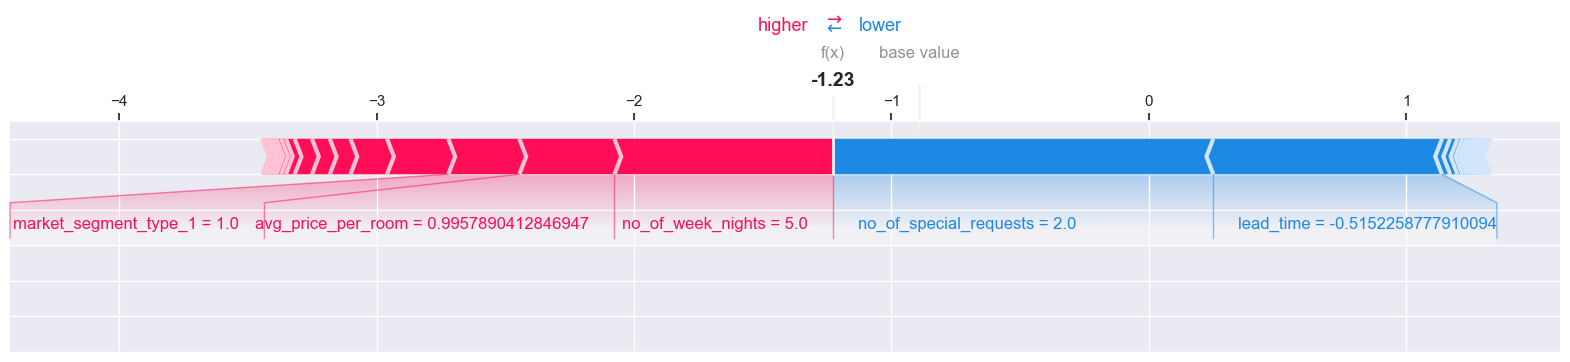

In [46]:
shap.force_plot(
    xgb_explainer.expected_value, 
    test_xgb_shap_values[eg_1], 
    X_test_transformed.iloc[eg_1], 
    matplotlib=True, 
    contribution_threshold=0.1
)

1.  For the first example, the forces drive the prediction value lower than the base value. In particular, the features `no_of_special_requests` and `lead_time` are the major contributors that lowers the raw prediction value. 

1.  The second example is index `105` in the test sample, which is classified as a positive class (`1`). The SHAP force plot is plotted as below: 

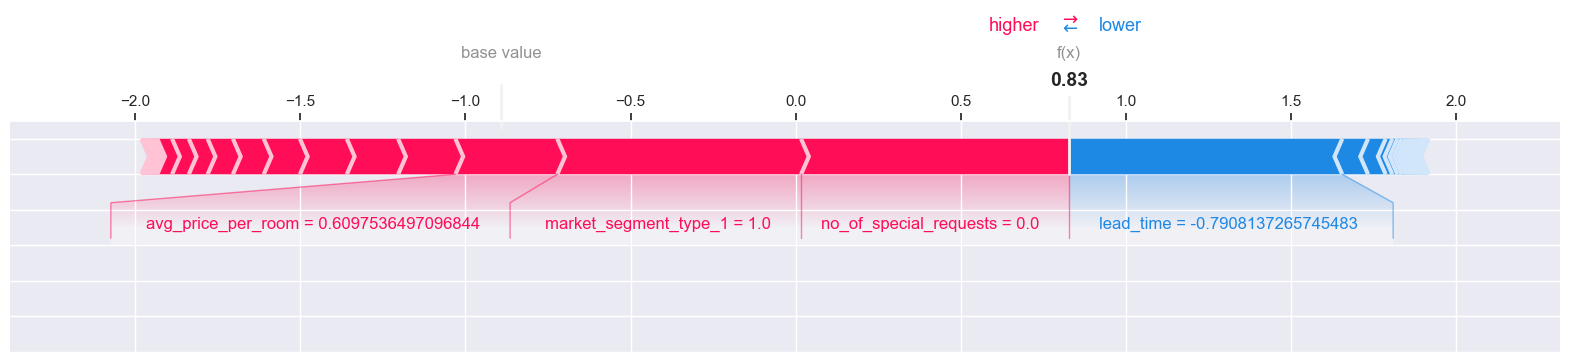

In [47]:
shap.force_plot(
    xgb_explainer.expected_value, 
    test_xgb_shap_values[eg_2], 
    X_test_transformed.iloc[eg_2], 
    matplotlib=True, 
    contribution_threshold=0.1
)

1.  For the second example, the forces drive the prediction value much higher than the base value. In particular, the features `no_of_special_requests` and `market_segment_type_1` are the major contributors that drives a higher raw prediction value. 

<br><br>

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

1. We used several machine learning models and techniques to build a predictive model and achieved an F1 score of `0.863` on the test set using an XGBClassifer model with feature selection and hyperparameter optimization (`learning_rate`=0.1, `gamma`=0.1). 

2. We explored a classification problem of predicting whether a customer will cancel a hotel reservation using the Reservation Cancellation Prediction Dataset.  We also used SHAP to explain the feature importances and individual predictions of the XGBoost model. Overall, we demonstrated the effectiveness of using machine learning for predicting hotel reservation cancellations and showed the importance of feature selection and hyperparameter optimization for improving model performance.

3. One potential idea for improving performance could be to collect additional data, such as customer reviews and feedback, to include in the feature set. This could potentially provide valuable insights into the reasons behind reservation cancellations and improve the predictive power of the model. Additionally, ensembling multiple models could be explored as another potential technique for improving performance. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 